# Project 2: Choose Your Own Ideas


After most of the classes and previous project and homeworks, you are now equipped with a powerful set of data mining and coding skills. In this project, you will work in teams to make use of these skills to come up with an idea based upon data science technology. Your goal is to design a service/solution, and prepare a pitch for your idea.

Your team needs to decide what problem is important for a specific market/domain (for example, social media market, housing market, search market, etc.). Then design a data science approach to solve the problem, or improve one of the current services or design a new service on any data that you choose.

This project is much more open ended.

**NOTE**
* Due Date: Dec 5, 2022, BEFORE 11:59PM EST
* Please download your code (notebook file as an ipynb file) and include it in your submission.
* There are always last minute issues submitting the project. DO NOT WAIT UNTIL THE LAST MINUTE!



### Two videos on storytelling

https://video.wpi.edu/Watch/g2T4NjBn

https://video.wpi.edu/Watch/q2A6Dbg3

**Optional Readings (APIs 
you can use for downloading data):** 
* LinkedIn API: https://developer.linkedin.com/docs/rest-api
* Zillow API: https://pypi.python.org/pypi/pyzillow
* Google Map API: https://developers.google.com/api-client-library/python/apis/mapsengine/v1?hl=en
* More APIs: https://github.com/ptwobrussell/Mining-the-Social-Web-2nd-Edition


**Python libraries you may want to use:**
* Scikit-learn (http://scikit-learn.org): machine learning tools in Python.

**Data sources:**
* UCI Machine Learning Repository: http://archive.ics.uci.edu/ml/ 
* Statlib datasets: http://lib.stat.cmu.edu/
* Kaggel: www.kaggle.com 
* Open Gov. Data: www.data.gov, www.data.gov.uk, www.data.gov.fr, http://opengovernmentdata.org/data/catalogues/   

**NOTE**
* Please don't forget to save the notebook frequently when working in IPython Notebook, otherwise the changes you made can be lost.


# Problem: pick a data science problem that you plan to solve 
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using the available data and data mining and machine learning solutions.

As a group, learn about the data science related business and research about the current markets: such as search, social media, advertisement, recommendation and so on. Pick one of the markets/domains for further consideration, find out a problem which you believe to be important in the market and design your solution. Define precisely in the report and briefly in the cells below, what is the business problem that your team wants to solve. Why the problem is important to solve? Why you believe you could make a big difference with data science technology.

Please briefly describe in the following cell: 

**1) The problem you trying to solve:**

We're trying to build a solution that can forecast foreign exchange(Fx) rates between two currencies where this could be performed between any pairs of currency like "USD-INR", "USD-GBP", "GBP-EUR" for any given time range which is easily configurable.

**2) Why the problem is important to solve?**

Currency prediction is required to assess the foreign-denominated cash flows involved in international transactions. Forecasting exchange rates is important for assessing the benefits and risks of the global economic environment.

**3) What is your idea to solve the problem?**

We are implementing a system that can accurately predict the exchange rate for any future day, even the one after that. Our evaluation method includes looking at the actual exchange rate (for the day we made our prediction) and computing the accuracy score.
We have utilized the DecisionTree Regresssor and MLP model to evaluate the extracted data. We try to forecast the data for the upcoming days using the prophet model. Using historical data obtained from marketdata.tradermade.com, we train the Prophet's algorithm to forecast data for future dates.

**4) What differences you could make with your data science approach?**

Using the data science approach to solve this problem will help us to accurately forecast exchange rates in future. This will help analysts and financial firms may make more calculated choices that will optimize returns and reduce risks. Governments can also make use of this to make resolutions for shaping their country's economy. Also, it will make it easier for people from various backgrounds to check the exchange rate of their money before investing in any sort of transaction due to business, travel, education etc. thereby allowing them to time their decision and buy/sell currencies at optimal rates.



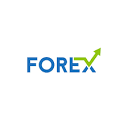
# ForeXcast 

**Members:**
- Rishank Karkera
- Atharv Mhatre
- Nivedita Gadade
- Preet Chaudhari


In [32]:
! pip install prophet

In [33]:
# library import
import requests
import datetime
from io import StringIO
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

# Data Collection: 

## Configure currencies and dates to apply prediction

In [34]:
# Enter start & end dates
start_date = datetime.date(2021, 12, 1)
end_date = datetime.date(2022, 12, 1)

# Enter source & target currencies
source_currency = "USD"
target_currency = "INR"

### Gather FX rate data for above params from API and pre-process it

In [35]:
# functions for getting fx data from api
API_URL = "https://marketdata.tradermade.com/api/v1"

def get_api_key():
    return open("api.key", mode='r').read()


def send_api_request(url):
    headers = {'Accept': 'application/json'}
    return requests.get(url=url, headers=headers)


def get_fx_data(source_currency, target_currency, start_date, end_date):
    api_key = get_api_key()
    url = f"{API_URL}/timeseries?currency={source_currency}{target_currency}&api_key={api_key}&start_date={start_date}&end_date={end_date}&format=csv"
    return send_api_request(url).text
 

def get_currency_df(source_currency, target_currency, start_date, end_date):
    currency_rates = get_fx_data(source_currency, target_currency, start_date, end_date)
    return pd.read_csv(StringIO(currency_rates), sep=",")


currency_df = get_currency_df(source_currency, target_currency, start_date, end_date)
currency_df

,date,open,high,low,close
0,2021-12-01,74.97124,75.10881,74.77473,75.00900
1,2021-12-02,75.01320,75.26833,74.86407,74.97580
2,2021-12-03,74.97530,75.48080,74.93500,75.32664
3,2021-12-06,75.24978,75.48105,75.15823,75.39134
4,2021-12-07,75.37476,75.49620,75.25400,75.43165
...,...,...,...,...,...
257,2022-11-25,81.63402,81.74599,81.40804,81.69398
258,2022-11-28,81.69398,81.83900,81.58302,81.63102
259,2022-11-29,81.63102,81.74899,81.51003,81.61402
260,2022-11-30,81.63198,81.72899,81.23106,81.36195


# Data Exploration: Exploring the Dataset

### Explore data, pattern for the provided exchange rate & dates

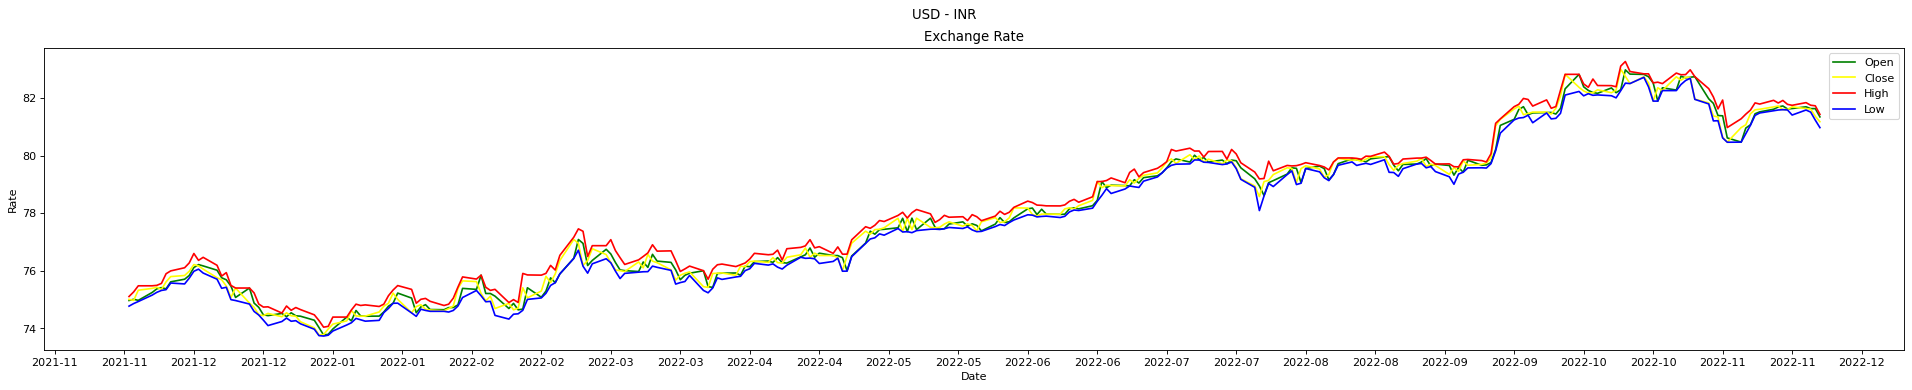

           open      high       low     close
open   1.000000  0.997475  0.997833  0.994642
high   0.997475  1.000000  0.997256  0.996933
low    0.997833  0.997256  1.000000  0.997869
close  0.994642  0.996933  0.997869  1.000000


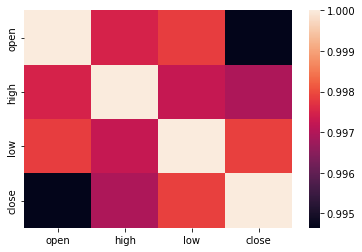

In [36]:
import matplotlib.dates as mdates

plt.figure(figsize=(30,5), dpi=80)
plt.suptitle(f"{source_currency} - {target_currency}")
plt.title(f"Exchange Rate")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))

plt.plot(pd.to_datetime(currency_df['date']), currency_df['open'], color='green', label='Open')
plt.plot(pd.to_datetime(currency_df['date']), currency_df['close'], color='yellow', label='Close')
plt.plot(pd.to_datetime(currency_df['date']), currency_df['high'], color='red', label='High')
plt.plot(pd.to_datetime(currency_df['date']), currency_df['low'], color='blue', label='Low')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Rate")
plt.show()

print(currency_df.corr())
sns.heatmap(currency_df.corr())
plt.show()

In [37]:
x = currency_df[["open", "high", "low"]].to_numpy()
y = currency_df["close"].to_numpy().reshape(-1, 1)

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

# Data Analysis: you can use different methods to solve the problem you proposed, and find out the best solution.

## 1. Applying Decision Tree Regression model
- Trained the model using training data
- Predicted results using testing data
- Identified score of predicted results vs actual result
- Plotted predicted and actual results to see the relationship between them

In [38]:
dtr_model = DecisionTreeRegressor()
dtr_model.fit(xtrain, ytrain)
dtr_y_pred = dtr_model.predict(xtest)

pred_data_decision_tree = pd.DataFrame(data={"Predicted Rate": dtr_y_pred.flatten()})
print("Score of the Decision Tree Regressor Model: ", dtr_model.score(xtest, ytest)*100)

Score of the Decision Tree Regressor Model:  99.06584522056514


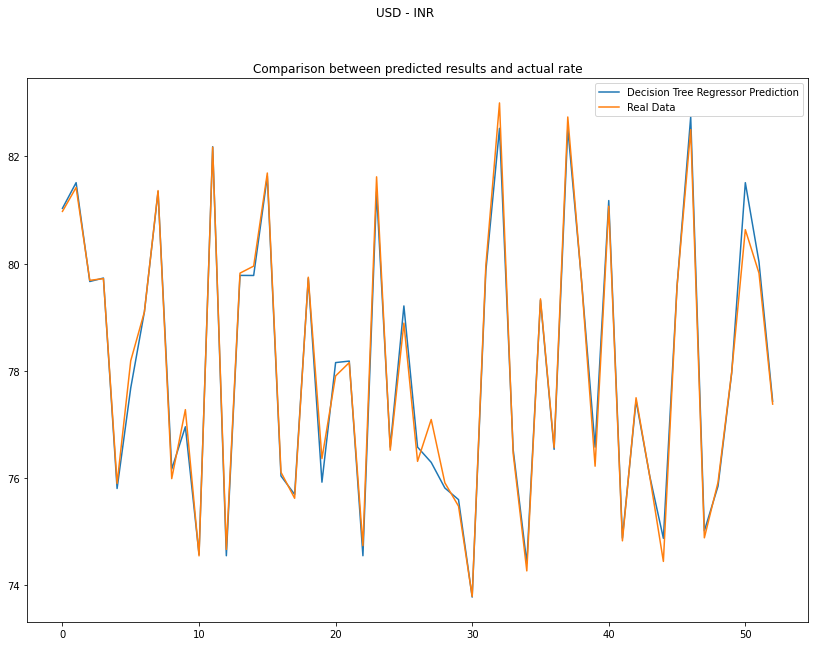

In [39]:
plt.figure(figsize=(14, 10))
plt.plot(dtr_y_pred, label = "Decision Tree Regressor Prediction")
plt.plot(ytest, label = "Real Data")
plt.suptitle(f"{source_currency} - {target_currency}")
plt.title(f"Comparison between predicted results and actual rate")
plt.legend()
plt.show()

## 2. Applying MLP (multilayer perceptron) neural network
- Trained the model using training data
- Predicted results using testing data
- Identified score of predicted results vs actual result
- Plotted predicted and actual results to see the relationship between them

In [40]:
mlp_model = MLPRegressor(activation='relu', max_iter = 4000, alpha = 100, hidden_layer_sizes=50, random_state=3, 
                   learning_rate_init=0.001, learning_rate='adaptive')

mlp_model.fit(xtrain, ytrain.flatten())
mlp_y_pred = mlp_model.predict(xtest)
print("Score of the MLP Model: ", mlp_model.score(xtest, ytest) * 100)

Score of the MLP Model:  98.58719414165327


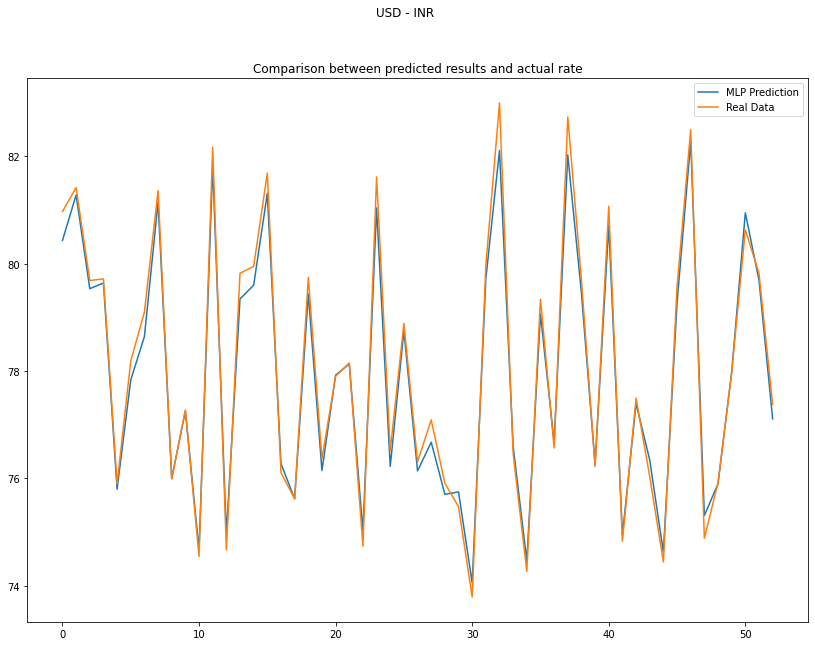

In [41]:
plt.figure(figsize=(14, 10))
plt.plot(mlp_y_pred, label = "MLP Prediction")
plt.plot(ytest, label = "Real Data")
plt.suptitle(f"{source_currency} - {target_currency}")
plt.title(f"Comparison between predicted results and actual rate")
plt.legend()
plt.show()

## Applying forecasting using Prophet model
- Extract timeseries data i.e 'ds' using 'date' and target i.e. 'y' as 'close' from currency dataframe
- We use this data to fit into prophet model
- We create future dataframe for next 90 days and forecast the closing rates using this model

In [42]:
# Prophet model requires a timeseries field (ds) and target(y) to forecast, 
# hence we extract date & close rates from currency dataframe
prophet_dataset = pd.DataFrame()
prophet_dataset['ds'] = pd.to_datetime(currency_df["date"])
prophet_dataset['y'] = pd.to_numeric(currency_df['close'])
prophet_dataset

,ds,y
0,2021-12-01,75.00900
1,2021-12-02,74.97580
2,2021-12-03,75.32664
3,2021-12-06,75.39134
4,2021-12-07,75.43165
...,...,...
257,2022-11-25,81.69398
258,2022-11-28,81.63102
259,2022-11-29,81.61402
260,2022-11-30,81.36195


In [43]:
# Fitting date and close rates in prophet model
prophet_basic = Prophet()
prophet_basic.fit(prophet_dataset)

# create timeseries dataframe including future dates
future_df = prophet_basic.make_future_dataframe(periods=90)
future_df

20:24:14 - cmdstanpy - INFO - Chain [1] start processing
20:24:15 - cmdstanpy - INFO - Chain [1] done processing


,ds
0,2021-12-01
1,2021-12-02
2,2021-12-03
3,2021-12-06
4,2021-12-07
...,...
347,2023-02-25
348,2023-02-26
349,2023-02-27
350,2023-02-28


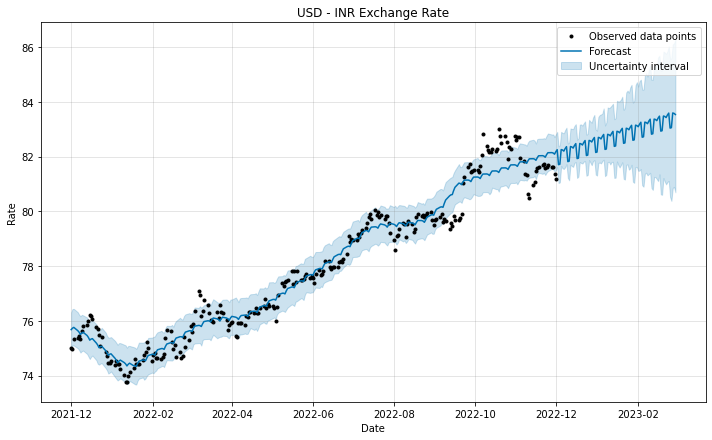

In [44]:
#predicting/forecasting close rates for future dates
forecast = prophet_basic.predict(future_df)
prophet_basic.plot(forecast)
plt.title(f"{source_currency} - {target_currency} Exchange Rate")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Rate")
plt.show()

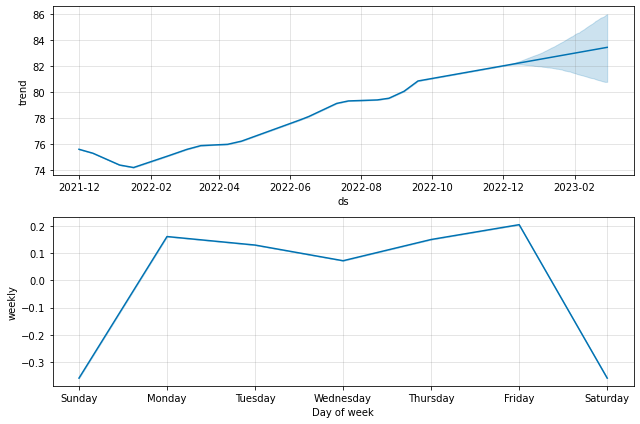

In [45]:
prophet_basic.plot_components(forecast)
plt.show()

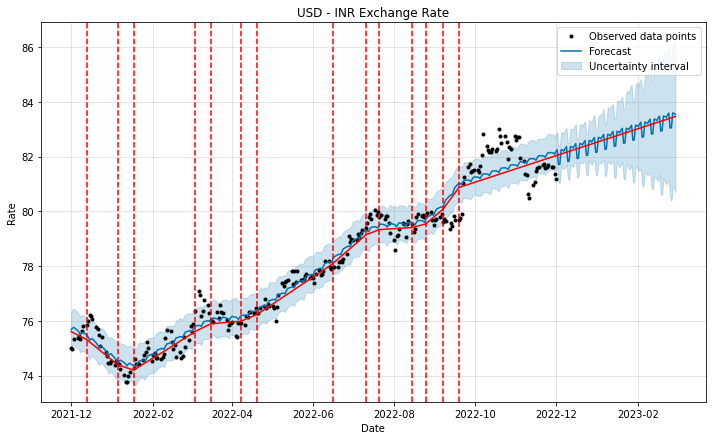

In [46]:
#Plotting forecasted results with changepoints
fig = prophet_basic.plot(forecast)
add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)
plt.title(f"{source_currency} - {target_currency} Exchange Rate")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Rate")
plt.show()


**Observation:** 
Changepoints helps us to understand the changing trends and their relevant dates

In [47]:
pd.DataFrame(prophet_basic.changepoints)

,ds
8,2021-12-13
17,2021-12-24
25,2022-01-05
33,2022-01-17
42,2022-01-28
50,2022-02-09
58,2022-02-21
67,2022-03-04
75,2022-03-16
83,2022-03-28


# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


As "Prophet" model is able to forecast currency prediction for future dates, let us try to evaluate our results further to strengthen above analysis

By default proportion of history in which trend changepoints will be estimated is 80%, we can tweak that 90 and see the change in prediction

20:24:17 - cmdstanpy - INFO - Chain [1] start processing
20:24:17 - cmdstanpy - INFO - Chain [1] done processing


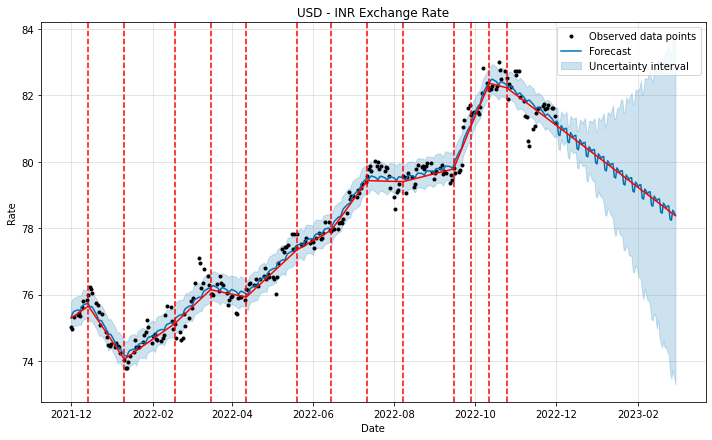

In [48]:
pro_change= Prophet(changepoint_range=0.9)
forecast = pro_change.fit(prophet_dataset).predict(future_df)
fig= pro_change.plot(forecast)
add_changepoints_to_plot(fig.gca(), pro_change, forecast)
plt.title(f"{source_currency} - {target_currency} Exchange Rate")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Rate")
plt.show()

As it appears there's a downwards trend for the future dates as compared to previous example due to change in changepoints range. This could mean that through more proportion of history in which trend changepoints are estimated, the results would vary. Since this is futuristic data, we couldn't be 100% sure, however we can try strengthening our model.

Hence we would need to add some features as regressor to train the model for better forecasting accuracy.

In [49]:
# setting up a new dataframe for regressor
currency_df_for_regressor = pd.DataFrame()
currency_df_for_regressor['ds'] = currency_df['date']
currency_df_for_regressor['y'] = currency_df['close']
currency_df_for_regressor['open'] = currency_df['open']
currency_df_for_regressor['high'] = currency_df['high']
currency_df_for_regressor['low'] = currency_df['low']

train, test = train_test_split(currency_df_for_regressor, test_size=0.3)



20:24:19 - cmdstanpy - INFO - Chain [1] start processing
20:24:19 - cmdstanpy - INFO - Chain [1] done processing


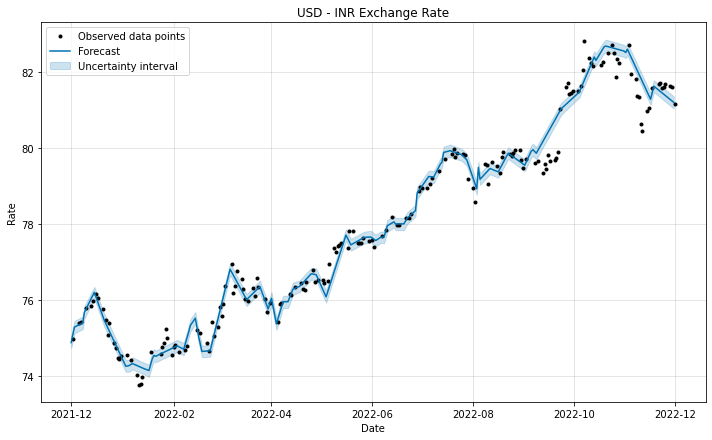

In [50]:

#Additional Regressor
pro_regressor = Prophet()
pro_regressor.add_regressor('open')
pro_regressor.add_regressor('high')
pro_regressor.add_regressor('low')

#Fitting the data
pro_regressor.fit(train)
future_data = pro_regressor.make_future_dataframe(periods=90)

#forecast the data for Test data
forecast_data = pro_regressor.predict(test)
pro_regressor.plot(forecast_data, uncertainty=True)
plt.title(f"{source_currency} - {target_currency} Exchange Rate")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Rate")
plt.show()


Here we were able to train and test data using prophet model where features `open`, `high`, `low` was used as a regressor. Now we'll try to predict future based on random outcomes of open values for the next 10 days.

In [51]:
days = 10
future_range = pd.date_range(end_date, periods=days, freq='D')
future_df = pd.DataFrame({ 'ds': future_range})

def find_estimate_range(df, feature):
    first = currency_df[-10:][feature].median()
    second = currency_df[-60:][feature].median()
    if first < second:
        return first, second
    else:
        return second, first


for feature in ['open', 'high', 'low']:
    start_estimate_range, end_estimate_range = find_estimate_range(currency_df, feature)
    for i in range (0, days):
        future_df.at[i, feature] = random.uniform(start_estimate_range, end_estimate_range)

future_df

,ds,open,high,low
0,2022-12-01,81.6315,81.806213,81.486289
1,2022-12-02,81.6315,81.851658,81.509627
2,2022-12-03,81.6315,81.811801,81.478647
3,2022-12-04,81.6315,81.837670,81.488633
4,2022-12-05,81.6315,81.835197,81.533274
5,2022-12-06,81.6315,81.856646,81.489218
6,2022-12-07,81.6315,81.841187,81.475073
7,2022-12-08,81.6315,81.817954,81.494883
8,2022-12-09,81.6315,81.836592,81.501033
9,2022-12-10,81.6315,81.785146,81.527705


Using above created data by using random values of `open`, `high`, `low` based on range of median between last 10 and 60 days we will try forecasting close rates

20:35:37 - cmdstanpy - INFO - Chain [1] start processing
20:35:38 - cmdstanpy - INFO - Chain [1] done processing


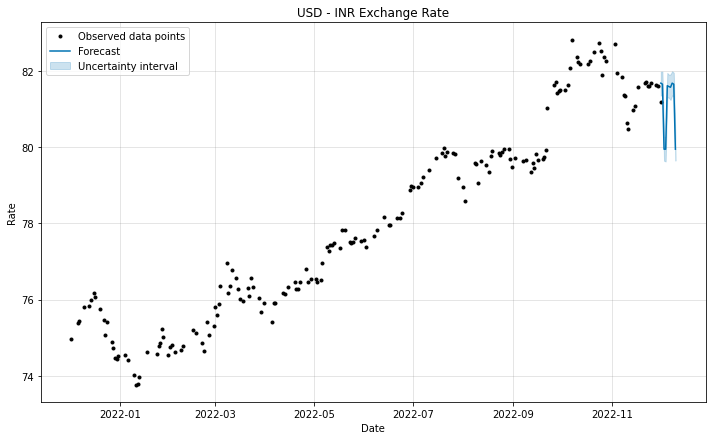

In [53]:
new_df = pd.DataFrame()
new_df['ds'] = pd.to_datetime(currency_df["date"])
new_df['y'] = pd.to_numeric(currency_df['close'])
new_df['open'] = pd.to_numeric(currency_df['open'])
new_df['high'] = pd.to_numeric(currency_df['high'])
new_df['low'] = pd.to_numeric(currency_df['low'])


m = Prophet()
m.add_regressor('open')
m.fit(new_df)
forecast = m.predict(future_df)
pro_regressor.plot(forecast, uncertainty=True, include_legend=True)
plt.title(f"{source_currency} - {target_currency} Exchange Rate")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.show()


Hence we're able to forecast rates using features `open`, `high`, `low` as a regressor in prophet model. Thus we're able to predict rates and with stronger analysis of identifying feature values we would be able to achieve higher accuracy

# Conclusion
We tried to apply 3 models for analysing and predicting currencies
1. Decision Tree Regressor
2. MLP
3. Prophet

- The first two models helped in analysing the data, understand the linearity and relationship of features like 'Open', 'High', 'Low' values
- The data didn't have any noise thus we could notice moving trends
- Since the data is based on timeseries, i.e. the target value 'close' varies based on dates we applied Prophet to evaluate result on timeseries.
- Using this we added above features as regressor and tried predicting rates for the future which could have a higher accuracy.
- This project supports predicting exchange rates for varying currencies with flexible time range.



# References
- https://www.earnforex.com/guides/high-low-vs-open-close/
- https://towardsdatascience.com/machine-learning-basics-decision-tree-regression-1d73ea003fda
- https://www.sciencedirect.com/topics/computer-science/multilayer-perceptron
- https://facebook.github.io/prophet/



# Done

All set! 

**What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. 

* **PDF Report**: please prepare a final report in the PDF form which should be at least 5 pages. The report should includes:

  * What is you motivation?

  * What data you collected?

  * How does this data support your product idea?

  * How did you analyse the data?

  * What did you find in the data?

  * (please include figures or tables in the report, but no source code)
  
* **PPT Slides**: please prepare PPT slides to present about the project. Each team present their case studies in class for 10 minutes. **Story-telling** is important, the slides should include:

  1. Motivation about the data collection, why the topic is interesting to you.

  2. Communicating Results (figure/table)

  3. Story telling (How all the parts (data, analysis, result) fit together as a story?)

Please compress all the files in a zipped file.

        
**Note: Each team only needs to submit one submission**